<a href="https://colab.research.google.com/github/ifedolapomi/Movies_recommendation/blob/main/realrecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Necessary Libraries

In [14]:
# import Required Libraries

import pandas as pd
import numpy as np


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing data

In [3]:
movies=pd.read_csv('/content/drive/MyDrive/movies_recommendation/movies.csv')
ratings=pd.read_csv('/content/drive/MyDrive/movies_recommendation/ratings.csv')

In [48]:
print(ratings.head())
ratings.shape

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


(100836, 4)

In [4]:
len(set(ratings['movieId']))

9724

In [5]:
len(set(ratings['userId']))

610

In [11]:
avg_userID= ratings.groupby('movieId')['userId'].mean().reset_index()
avg_userID.head()

,movieId,userId
0,1,306.530233
1,2,329.554545
2,3,283.596154
3,4,219.857143
4,5,299.571429


In [12]:
print(avg_userID.shape)

(9724, 2)


In [13]:
avg_rating= ratings.groupby('movieId')['rating'].mean().reset_index()
avg_rating.head()

,movieId,rating
0,1,3.920930
1,2,3.431818
2,3,3.259615
3,4,2.357143
4,5,3.071429


In [15]:
avg_rating.shape

(9724, 2)

In [20]:
# Compute the average rating for each movie
#average_ratings = movies.groupby('movieId')['rating'].mean()

# Merge the average rating with the movie details
movie_data = movies[['movieId', 'title', 'genres']].drop_duplicates()
movie_data = movie_data.merge(avg_rating, on='movieId', how='left')
movie_data=movie_data.merge(avg_userID, on='movieId', how='left')
# Rename the 'rating' column to 'average_rating'
movie_data.rename(columns={'rating': 'average_rating'}, inplace=True)

# Display the movie data with average ratings
print(movie_data.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  average_rating      userId  
0  Adventure|Animation|Children|Comedy|Fantasy        3.920930  306.530233  
1                   Adventure|Children|Fantasy        3.431818  329.554545  
2                               Comedy|Romance        3.259615  283.596154  
3                         Comedy|Drama|Romance        2.357143  219.857143  
4                                       Comedy        3.071429  299.571429  


In [21]:
movie_data.shape

(9742, 5)

In [22]:
movie_data.describe()

,movieId,average_rating,userId
count,9742.000000,9724.000000,9724.000000
mean,42200.353623,3.262448,355.903752
std,52160.494854,0.869874,134.553939
min,1.000000,0.500000,1.000000
25%,3248.250000,2.800000,291.734127
50%,7300.000000,3.416667,345.500000
75%,76232.000000,3.911765,448.000000
max,193609.000000,5.000000,610.000000


In [ ]:
#movies['genres'] = movies['genres'].str.replace('|', ', ')


In [23]:
#movies['genres'].head()

Exploratory Data Analysis

In [25]:
movie_data.head(2)

,movieId,title,genres,average_rating,userId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.920930,306.530233
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.431818,329.554545


In [35]:
#finding the missing value
missing_value = movie_data['average_rating'].isnull().sum() | movie_data['userId'].isnull().sum()
print(missing_value)

18


In [38]:
#drop the missing rows
movies_clean = movie_data.dropna(subset=['average_rating','userId'])

In [39]:
movies_clean.describe()

,movieId,average_rating,userId
count,9724.000000,9724.000000,9724.000000
mean,42245.024373,3.262448,355.903752
std,52191.137320,0.869874,134.553939
min,1.000000,0.500000,1.000000
25%,3245.500000,2.800000,291.734127
50%,7300.000000,3.416667,345.500000
75%,76739.250000,3.911765,448.000000
max,193609.000000,5.000000,610.000000


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns


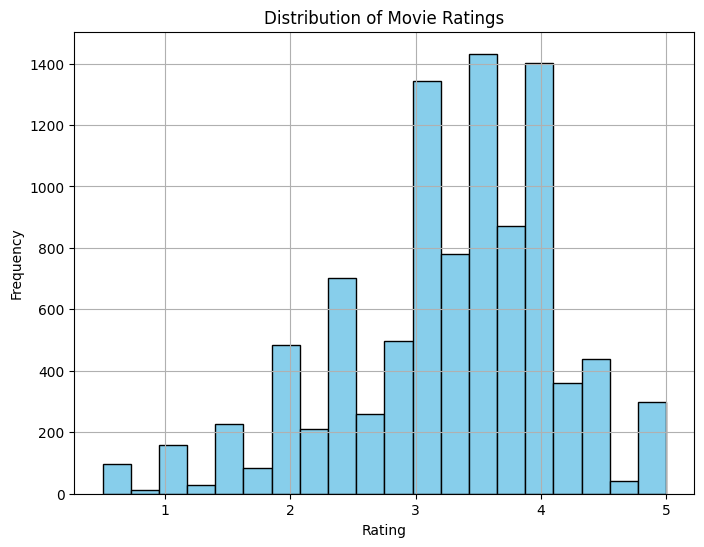

In [42]:
# Create a histogram for the 'rating' column
plt.figure(figsize=(8, 6))
plt.hist(movies_clean['average_rating'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [44]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357279 sha256=b85ea9143ca910a1cf4bed32d3d591943aa13becab23826a7eed7f40201ae0e7
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [45]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from surprise import KNNWithMeans


In [46]:
# Split genres by "|"
movies_clean['genres'] = movies_clean['genres'].str.split('|')

<ipython-input-46-1890f1282789>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_clean['genres'] = movies_clean['genres'].str.split('|')


In [47]:
movies_clean.head(2)

,movieId,title,genres,average_rating,userId
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.920930,306.530233
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.431818,329.554545


In [49]:
user_movie_matrix = movies_clean.pivot_table(index='userId', columns='movieId', values='average_rating')

# Fill missing ratings with 0 (this can be adjusted for other strategies)
user_movie_matrix = user_movie_matrix.fillna(0)

# Encode genres for the new user scenario (map genres to each movie)
movies_clean['genre_encoded'] = movies_clean['genres'].apply(lambda x: ' '.join(x))

# Show the processed dataframe
movies_clean.head()

<ipython-input-49-30b9a06237c4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_clean['genre_encoded'] = movies_clean['genres'].apply(lambda x: ' '.join(x))


,movieId,title,genres,average_rating,userId,genre_encoded
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.920930,306.530233,Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.431818,329.554545,Adventure Children Fantasy
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.259615,283.596154,Comedy Romance
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",2.357143,219.857143,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),[Comedy],3.071429,299.571429,Comedy


In [50]:
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(user_movie_matrix.to_numpy(), k=50)  # k is the number of latent factors

# Convert sigma to diagonal matrix
sigma = np.diag(sigma)
predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Convert back to DataFrame for readability
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=user_movie_matrix.columns, index=user_movie_matrix.index) # Add index to preserve user IDs

In [55]:
# Function to recommend movies based on genres for a new user
def recommend_movies_by_genre(favorite_genres, movie_df, top_n=5):
    recommended_movies = movie_df[movie_df['genre_encoded'].apply(lambda x: any(genre in x for genre in favorite_genres))]

    # Sort by average rating or another criterion
    recommended_movies = recommended_movies.sort_values(by='average_rating', ascending=False)

    # Return the top N recommended movies
    return recommended_movies[['title', 'genres']].head(top_n)

# Example of recommending movies to a new user based on favorite genres
new_user_fav_genres = ['Comedy']  # This can be input by the user
recommended_movies = recommend_movies_by_genre(new_user_fav_genres, movies_clean)
print(recommended_movies)


                                                  title  \
7513                          Down Argentine Way (1940)   
7656              Paper Birds (Pájaros de papel) (2010)   
7760  Asterix and the Vikings (Astérix et les Viking...   
3067                           Hollywood Shuffle (1987)   
7761                              Happy Feet Two (2011)   

                                                 genres  
7513                           [Comedy, Drama, Romance]  
7656                                    [Comedy, Drama]  
7760  [Adventure, Animation, Children, Comedy, Fantasy]  
3067                                           [Comedy]  
7761                [Animation, Children, Comedy, IMAX]  


In [56]:
from sklearn.metrics import mean_squared_error

# Calculate MSE between actual and predicted ratings for test users
mse = mean_squared_error(user_movie_matrix.values.flatten(), predicted_ratings_df.values.flatten())
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.001862787493176502
